<a href="https://colab.research.google.com/github/ShinHyun-soo/pet-skin-disease-classifier-tensorfow-lite-sample/blob/main/mobilevit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileViT: A mobile-friendly Transformer-based model for image classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/10/20<br>
**Last modified:** 2021/10/20<br>
**Description:** MobileViT for image classification with combined benefits of convolutions and Transformers.

## Introduction

In this example, we implement the MobileViT architecture
([Mehta et al.](https://arxiv.org/abs/2110.02178)),
which combines the benefits of Transformers
([Vaswani et al.](https://arxiv.org/abs/1706.03762))
and convolutions. With Transformers, we can capture long-range dependencies that result
in global representations. With convolutions, we can capture spatial relationships that
model locality.

Besides combining the properties of Transformers and convolutions, the authors introduce
MobileViT as a general-purpose mobile-friendly backbone for different image recognition
tasks. Their findings suggest that, performance-wise, MobileViT is better than other
models with the same or higher complexity ([MobileNetV3](https://arxiv.org/abs/1905.02244),
for example), while being efficient on mobile devices.

## Imports

In [1]:
!pip install tensorflow_addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

from keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyperparameters

In [ ]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 256
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.

In [3]:
import tensorflow as tf

def conv_bn_relu(x, filters, kernel_size, strides):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def depthwise_separable_conv(x, filters, kernel_size, strides):
    x = tf.keras.layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def MobileNetV1(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = conv_bn_relu(inputs, 32, 3, strides=2)
    x = depthwise_separable_conv(x, 64, 3, strides=1)
    x = depthwise_separable_conv(x, 128, 3, strides=2)
    x = depthwise_separable_conv(x, 128, 3, strides=1)
    x = depthwise_separable_conv(x, 256, 3, strides=2)
    x = depthwise_separable_conv(x, 256, 3, strides=1)
    x = depthwise_separable_conv(x, 512, 3, strides=2)

    for _ in range(5):  # Add 5 depthwise separable convolutions with stride 1
        x = depthwise_separable_conv(x, 512, 3, strides=1)

    x = depthwise_separable_conv(x, 1024, 3, strides=2)
    x = depthwise_separable_conv(x, 1024, 3, strides=2)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1, 1, 1024))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Softmax()(x)

    model = tf.keras.Model(inputs, outputs, name='MobileNetV1')
    return model

# Example usage
input_shape = (224, 224, 3)
num_classes = 1000  # Change this to the number of classes in your specific task
model = MobileNetV1(input_shape, num_classes)
model.summary()


Model: "MobileNetV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 112, 112, 32)     320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)     

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow import keras
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          validation_split=0.2)

In [32]:
train_dataset = img_gen.flow_from_directory(directory="/content/drive/MyDrive/train/",
                                        target_size = (224,224),
                                        class_mode='categorical',
                                        subset='training',
                                        batch_size = 32)



Found 879 images belonging to 10 classes.


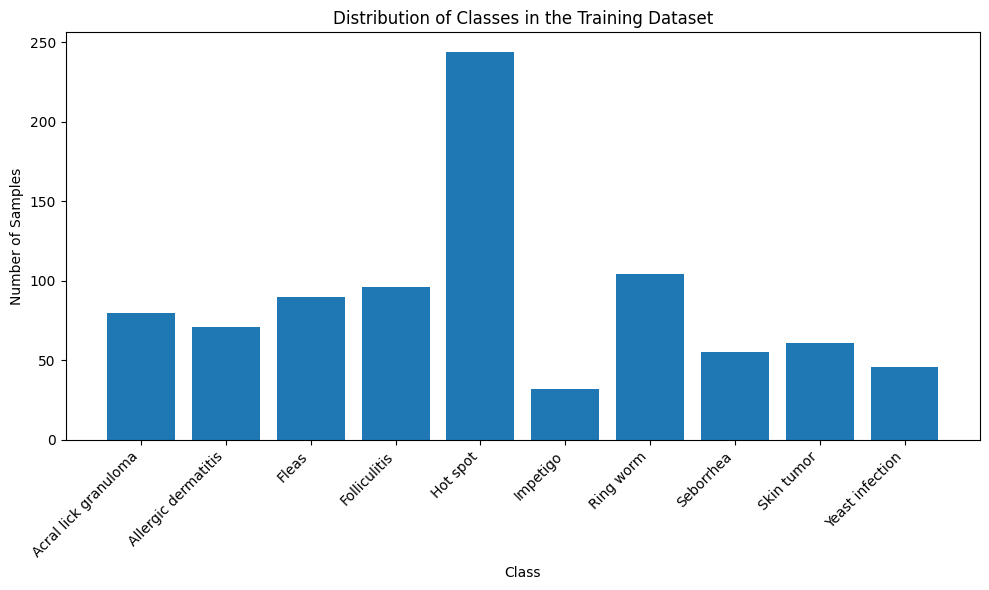

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Get the mapping of class names to indices from the train_dataset
class_indices = train_dataset.class_indices

# Extract class names and their corresponding indices
class_names = list(class_indices.keys())
class_indices = list(class_indices.values())

# Convert train_dataset.classes to a numpy array for easier filtering
classes_array = np.array(train_dataset.classes)

# Get the number of samples in each class
num_samples_per_class = [np.sum(classes_array == idx) for idx in class_indices]

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
plt.bar(class_names, num_samples_per_class)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in the Training Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [34]:
val_dataset = img_gen.flow_from_directory(directory="/content/drive/MyDrive/train/",
                                        target_size = (224,224),
                                        class_mode='categorical',
                                        subset='validation',
                                        shuffle = False,
                                        batch_size = 32)

Found 214 images belonging to 10 classes.


## Train a MobileViT (XXS) model

In [ ]:
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 60

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)


from keras.callbacks import LearningRateScheduler

# Learning rate schedule function (you can customize this function)
def lr_schedule(epoch, learning_rate=0.002):
    if epoch < 30:
        return learning_rate
    elif epoch < 45:
        return learning_rate * 0.1
    else:
        return learning_rate * 0.01

# Modify run_experiment function to include LearningRateScheduler
def run_experiment(epochs=epochs):
    mobilevit_xxs = MobileNetV1((224, 224, 3), 10)
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    lr_scheduler = LearningRateScheduler(lr_schedule)

    mobilevit_xxs.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback, lr_scheduler],
    )
    mobilevit_xxs.load_weights(checkpoint_filepath)
    _, accuracy = mobilevit_xxs.evaluate(val_dataset)
    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")
    return mobilevit_xxs

mobilevit_xxs = run_experiment()

Epoch 1/60
28/28 [==============================] - 25s 257ms/step - loss: 2.3736 - accuracy: 0.2662 - val_loss: 2.1849 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 2/60
28/28 [==============================] - 6s 195ms/step - loss: 2.0351 - accuracy: 0.3504 - val_loss: 2.1915 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 3/60
28/28 [==============================] - 6s 200ms/step - loss: 1.9599 - accuracy: 0.3845 - val_loss: 2.2554 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 4/60
28/28 [==============================] - 5s 195ms/step - loss: 1.8233 - accuracy: 0.4391 - val_loss: 2.2852 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 5/60
28/28 [==============================] - 6s 200ms/step - loss: 1.8111 - accuracy: 0.4437 - val_loss: 2.4061 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 6/60
28/28 [==============================] - 6s 195ms/step - loss: 1.6556 - accuracy: 0.5301 - val_loss: 2.5305 - val_accuracy: 0.2850 - lr: 0.0020
Epoch 7/60
28/28 [==============================] - 5s 195ms/step - l

## Results and TFLite conversion

With about one million parameters, getting to ~85% top-1 accuracy on 256x256 resolution is
a strong result. This MobileViT mobile is fully compatible with TensorFlow Lite (TFLite)
and can be converted with the following code:

In [10]:
# Serialize the model as a SavedModel.
mobilevit_xxs.save("mobilevit_xxs")

# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("mobilevit_xxs")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops.
]
tflite_model = converter.convert()
open("mobilevit_xxs.tflite", "wb").write(tflite_model)

3402616

In [11]:
!pip install tflite-support


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 25.6 MB/s eta 0:00:00


In [12]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [13]:
from tflite_support import metadata_schema_py_generated as _metadata_fb
##%%
""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileNetV1 Pet skin disease classifier"
model_meta.description = ("Classify Pet skin disease")
model_meta.version = "v2"
model_meta.author = "BEOKS"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [14]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [15]:
# Creates outputs info.
output_location_meta = _metadata_fb.TensorMetadataT()
output_location_meta.name = "location"
output_location_meta.description = "The locations of the detected boxes."
output_location_meta.content = _metadata_fb.ContentT()
output_location_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.BoundingBoxProperties)
output_location_meta.content.contentProperties = (
    _metadata_fb.BoundingBoxPropertiesT())
output_location_meta.content.contentProperties.index = [1, 0, 3, 2]
output_location_meta.content.contentProperties.type = (
    _metadata_fb.BoundingBoxType.BOUNDARIES)
output_location_meta.content.contentProperties.coordinateType = (
    _metadata_fb.CoordinateType.RATIO)
output_location_meta.content.range = _metadata_fb.ValueRangeT()
output_location_meta.content.range.min = 2
output_location_meta.content.range.max = 2
output_class_meta = _metadata_fb.TensorMetadataT()
output_class_meta.name = "category"
output_class_meta.description = "The categories of the detected boxes."
output_class_meta.content = _metadata_fb.ContentT()
output_class_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_class_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_class_meta.content.range = _metadata_fb.ValueRangeT()
output_class_meta.content.range.min = 2
output_class_meta.content.range.max = 2
label_file = _metadata_fb.AssociatedFileT()
label_file.name = 'label.txt'
label_file.description = "Label of objects that this model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_VALUE_LABELS
output_class_meta.associatedFiles = [label_file]
output_score_meta = _metadata_fb.TensorMetadataT()
output_score_meta.name = "score"
output_score_meta.description = "The scores of the detected boxes."
output_score_meta.content = _metadata_fb.ContentT()
output_score_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_score_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())
output_score_meta.content.range = _metadata_fb.ValueRangeT()
output_score_meta.content.range.min = 2
output_score_meta.content.range.max = 2
output_number_meta = _metadata_fb.TensorMetadataT()
output_number_meta.name = "number of detections"
output_number_meta.description = "The number of the detected boxes."
output_number_meta.content = _metadata_fb.ContentT()
output_number_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_number_meta.content.contentProperties = (
    _metadata_fb.FeaturePropertiesT())

In [20]:
group = _metadata_fb.TensorGroupT()
group.name = "detection result"
group.tensorNames = [
    output_location_meta.name, output_class_meta.name,
    output_score_meta.name
]
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [
    output_class_meta
]
subgraph.outputTensorGroups = [group]
model_meta.subgraphMetadata = [subgraph]
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadta_buf = b.Output()

In [24]:
populator = _metadata.MetadataPopulator.with_model_file("/content/mobilevit_xxs.tflite")
populator.load_metadata_buffer(metadta_buf)
populator.load_associated_files(["/content/drive/MyDrive/label.txt"])
populator.populate()

ValueError: ignored